### 1. Imports y lectura de datos

In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from utils.embedding import EmbeddingDataset, mae_por_class

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
# load data
cajcodes = pd.read_parquet("../data/embeddings/cajcodes-embeddings.parquet")
tweets = pd.read_parquet("../data/embeddings/tweets-embeddings.parquet")

### 3. Entrenamiento sobre ```political-leaning-tweets```

In [4]:
label_map = {"L": -1, "C": 0, "R": 1}
tweets["label"] = tweets["label"].map(label_map)

X = np.vstack(tweets["embedding"].values)
y = tweets["label"].values

#### a. Google Embeddings + Ordinal RidgeReg

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("R^2:", r2)

MAE: 0.5029268787785369
R^2: 0.38108744135824457


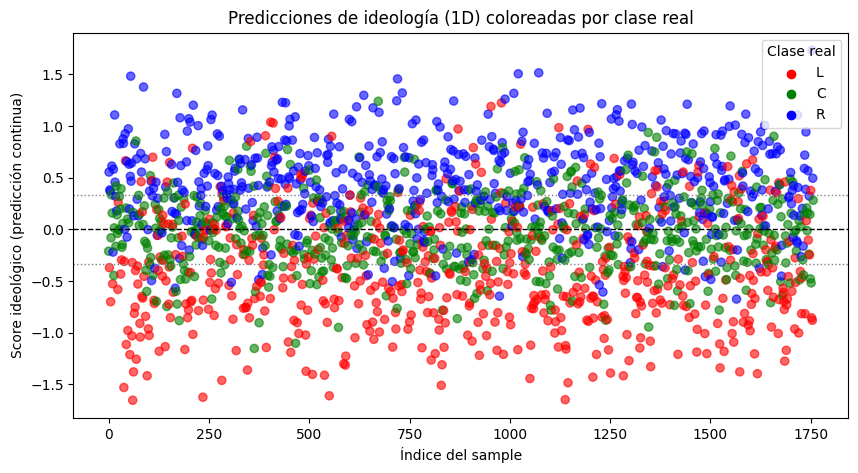

In [6]:
# Convert true numeric labels back to class labels
numeric_to_class = { -1: "L", 0: "C", 1: "R" }
true_classes = np.array([numeric_to_class[v] for v in y_test])

# Color map
colors = {"L": "red", "C": "green", "R": "blue"}
point_colors = [colors[c] for c in true_classes]

plt.figure(figsize=(10, 5))

# Plot in 1D — X = index of sample, Y = predicted ideology score
plt.scatter(
    np.arange(len(y_pred)), 
    y_pred, 
    c=point_colors, 
    alpha=0.6,
    s=35
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(0.33, color="gray", linestyle=":", linewidth=1)
plt.axhline(-0.33, color="gray", linestyle=":", linewidth=1)

plt.title("Predicciones de ideología (1D) coloreadas por clase real")
plt.xlabel("Índice del sample")
plt.ylabel("Score ideológico (predicción continua)")

# Leyenda manual
for label, color in colors.items():
    plt.scatter([], [], c=color, label=label)
plt.legend(title="Clase real")

plt.show()


#### b. Google Embeddings + MLP

In [10]:
train_ds = EmbeddingDataset(X_train, y_train)
test_ds  = EmbeddingDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)
input_dim = X.shape[1]

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1), 
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

model = MLP(input_dim).to(device)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 400

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        first_str = f"Epoch {epoch+1}/{epochs}  "
        print(f"{first_str}|  Train Loss: {total_loss/len(train_loader):.4f}")
        # Evaluate on test set
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        mae = mean_absolute_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)
        print(f'{" " * len(first_str)}|  Test MAE: {mae:.4f}  |  Test R^2: {r2:.4f}')

Epoch 10/400  |  Train Loss: 0.2790
              |  Test MAE: 0.4456  |  Test R^2: 0.4401
Epoch 20/400  |  Train Loss: 0.1642
              |  Test MAE: 0.4272  |  Test R^2: 0.4183
Epoch 30/400  |  Train Loss: 0.1203
              |  Test MAE: 0.4343  |  Test R^2: 0.3974
Epoch 40/400  |  Train Loss: 0.1044
              |  Test MAE: 0.4306  |  Test R^2: 0.4019
Epoch 50/400  |  Train Loss: 0.0919
              |  Test MAE: 0.4307  |  Test R^2: 0.3849
Epoch 60/400  |  Train Loss: 0.0891
              |  Test MAE: 0.4415  |  Test R^2: 0.3775
Epoch 70/400  |  Train Loss: 0.0867
              |  Test MAE: 0.4287  |  Test R^2: 0.3776
Epoch 80/400  |  Train Loss: 0.0819
              |  Test MAE: 0.4380  |  Test R^2: 0.3672
Epoch 90/400  |  Train Loss: 0.0768
              |  Test MAE: 0.4299  |  Test R^2: 0.3721
Epoch 100/400  |  Train Loss: 0.0771
               |  Test MAE: 0.4332  |  Test R^2: 0.3726
Epoch 110/400  |  Train Loss: 0.0728
               |  Test MAE: 0.4304  |  Test R^2: 0.

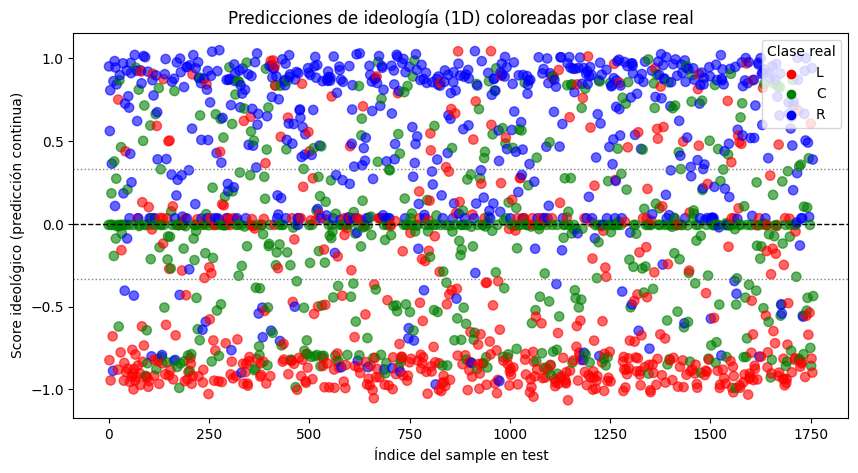

In [12]:
plt.figure(figsize=(10, 5))

plt.scatter(
    np.arange(len(all_preds)),
    all_preds,
    c=point_colors,
    alpha=0.6,
    s=45
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(0.33, color="gray", linestyle=":", linewidth=1)
plt.axhline(-0.33, color="gray", linestyle=":", linewidth=1)

plt.title("Predicciones de ideología (1D) coloreadas por clase real")
plt.xlabel("Índice del sample en test")
plt.ylabel("Score ideológico (predicción continua)")

# leyenda manual
for label, color in colors.items():
    plt.scatter([], [], c=color, label=label)
plt.legend(title="Clase real")

### 4. Evaluación de modelos en ```cajcodes```

Se decidió entrenar en tweets y evaluar en cajcodes dado que el segundo es más sencillo de predecir, dado que está generado con GPT.

#### a. LogReg

In [10]:
y_pred_lr_caj = best_lr.predict(X_caj)
acc_lr_caj = accuracy_score(y_caj, y_pred_lr_caj)
print(f"[LogReg L2] tweets(train) -> cajcodes accuracy = {acc_lr_caj:.4f}\n")
print(classification_report(y_caj, y_pred_lr_caj, target_names=le.classes_))

[LogReg L2] tweets(train) -> cajcodes accuracy = 0.4475

              precision    recall  f1-score   support

           C       0.00      0.00      0.00       201
           L       0.35      0.98      0.52       195
           R       0.93      0.39      0.55       261

    accuracy                           0.45       657
   macro avg       0.43      0.46      0.36       657
weighted avg       0.47      0.45      0.37       657



#### b. RoBERTa

In [11]:
texts = cajcodes["text"].astype(str).tolist()
y_true_int = y_caj  # enteros codificados
labels_original = np.array(y_caj_raw)  # nombres originales
classes_order = list(pd.Index(labels_original).unique())

batch_size = 32
all_preds_int = []

def iter_batches(seq, batch_size):
    for i in range(0, len(seq), batch_size):
        yield seq[i:i+batch_size]
        
with torch.no_grad():
    for batch_texts in iter_batches(texts, batch_size):
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        outputs = model_bert(**enc)
        logits = outputs.logits  # (B, num_labels)
        preds = torch.argmax(logits, dim=-1)
        all_preds_int.extend(preds.cpu().numpy())

y_pred_bert_caj = np.array(all_preds_int)

In [12]:
report = classification_report(
    y_caj,
    y_pred_bert_caj,
    target_names=["L", "C", "R"],
    digits=4
)

acc_lr_bert = accuracy_score(y_caj, y_pred_bert_caj)
print(f"\n[Pretrained RoBERTa] tweets(train) -> cajcodes accuracy = {round(acc_lr_bert, 3)}")
print("Classification Report - RoBERTa Political Bias\n")
print(report)


[Pretrained RoBERTa] tweets(train) -> cajcodes accuracy = 0.285
Classification Report - RoBERTa Political Bias

              precision    recall  f1-score   support

           L     0.2993    0.2040    0.2426       201
           C     0.2643    0.6154    0.3698       195
           R     0.3939    0.0996    0.1590       261

    accuracy                         0.2846       657
   macro avg     0.3192    0.3063    0.2571       657
weighted avg     0.3265    0.2846    0.2472       657



### c. MLP

In [13]:
X_caj_t = torch.tensor(X_caj, dtype=torch.float32, device=device)
y_caj_t = torch.tensor(y_caj, dtype=torch.long, device=device)

mlp_model.eval()
with torch.inference_mode():
    logits = mlp_model(X_caj_t)
    y_pred_caj_t = logits.argmax(dim=1)

y_pred_caj_mlp = y_pred_caj_t.detach().cpu().numpy()

# --- métricas ---
acc_caj = accuracy_score(y_caj_t.cpu(), y_pred_caj_mlp)
print(f"[MLP (PyTorch)] Cajcodes(train) -> Twinviews accuracy = {acc_caj:.4f}")
print(classification_report(y_caj_t.cpu(), y_pred_caj_mlp, target_names=le.classes_))

[MLP (PyTorch)] Cajcodes(train) -> Twinviews accuracy = 0.4460
              precision    recall  f1-score   support

           C       0.00      0.00      0.00       201
           L       0.35      0.99      0.52       195
           R       0.91      0.38      0.54       261

    accuracy                           0.45       657
   macro avg       0.42      0.46      0.35       657
weighted avg       0.47      0.45      0.37       657



/Users/diegolarraguibel/Desktop/Proyectos/inclinacion_politica/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/diegolarraguibel/Desktop/Proyectos/inclinacion_politica/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/diegolarraguibel/Desktop/Proyectos/inclinacion_politica/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl